# Udacity DS Project 1 - Write a Data Science Blog Post

## Business Understanding

This is Project 1 of the Udacity Data Scientist Nanodegree. In this project a data analysis is done on AirBnB listings data for the city of Seattle. The dataset was provided by AirBnB and hosted on Kaggle. In this analysis we attempt to answer three business questions:

    1. What are the average listing prices in various neighborhoods in Seattle?
    2. What contributes to higher listing prices?
    3. How do I get a high rating for my listings?

## Data Understanding
### Access and Explore

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

#Read in Seattle AirBnB listings data
df = pd.read_csv('listings.csv')

#Overview of data
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


## Prepare Data
### Clean
There's quite a few things we need to do to clean up this data before we can process it:
1. Convert columns with $ signs (stored as strings) to numerical - columns such as price have the numbers stored as text, they need to be converted to numerical.
2. Convert columns with 't' of 'f' to 1 or 0 numerical
3. Convert amenities column into dummy variable columns for each type of amenity - currently the amenities column has a list of amenities for each listing
4. Drop columns that have most or all NaN values - we will drop all columns for which more than half of values are NaN
5. Convert some relevant categorical columns to dummy variable columns
6. Clean up the names of the columns/variables so that they are easier to read in the visualizations


In [150]:
#Convert columns with $ signs (stored as strings) to numerical
for col in ['price','cleaning_fee','extra_people']:
    df[col] = pd.to_numeric(df[col].str.replace('$','').str.replace(',',''))

C:\Users\Hashim\AppData\Local\Temp\ipykernel_19556\3213236557.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = pd.to_numeric(df[col].str.replace('$','').str.replace(',',''))


In [151]:
#Find the names of all columns that have 't' or 'f' true/false values and put them in cat_col_names
cat_col_names = []
for col in df.columns:
    if df.loc[0,col] in ['t','f']:
        cat_col_names.append(col)

#Convert columns with true or false values to 1 or 0 numerical instead
for cat_col_name in cat_col_names:
    cat_col = list(df[cat_col_name])
    
    for i, val in enumerate(cat_col):
        if val == 't':
            cat_col[i] = 1
        elif val == 'f':
            cat_col[i] = 0
        else:
            cat_col[i] = 0.5
            
    df[cat_col_name] = cat_col

In [152]:
#Convert amenities column into dummy variable columns for each type of amenity

def lists_to_columns(amenities):
    """
    Converts a column of lists to a set of dummy columns, one for each type of type of unique element in the lists

    Parameters
    ----------
    amenities (list) : amenities column

    Returns
    -------
    dataframe
        dataframe has same length of original amenities column but has new columns, one for each type of element in the amenities list.

    """
    master_str = ''
    for i, listing in enumerate(amenities):
        listing = listing.replace('"','').replace('{',',').replace('}','')
        master_str = master_str + listing
        amenities[i] = listing[1:]
    master_set = list(set(master_str.split(',')[1:]))[1:]
    
    df_amen_data = []
    for i, listing in enumerate(amenities):
        new_row = []
        for x, amen in enumerate(master_set):
            if amen in listing:
                new_row.append(1)
            else:
                new_row.append(0)
        df_amen_data.append(new_row)
    return pd.DataFrame(df_amen_data, columns = master_set)

df_amen = lists_to_columns(list(df['amenities']))
df = pd.concat([df, df_amen], axis=1)

In [153]:
#Drop columns that have most or all NaN values
nan_counts = df.isnull().sum(axis = 0)

len_df = len(df)
for col in nan_counts.index:
    #If more than half of the values are NaN
    if nan_counts[col] > (0.5*len_df):
        df = df.drop(col, axis=1)

In [154]:
#Covert some relevant categorical columns to dummy variable columns
df = pd.get_dummies(df, columns=['host_response_time', 'cancellation_policy','property_type']).reset_index(drop=True)

In [155]:
#Clean up the names of the columns/variables so that they are easier to read in the visualizations
new_cols = []
for col in df.columns:
    new_cols.append(col.replace('_',' ').title())
df.columns = new_cols

In [156]:
#Descriptive stats of dataset after we have made the above changes
df.describe()

,Id,Scrape Id,Host Id,Host Is Superhost,Host Listings Count,Host Total Listings Count,Host Has Profile Pic,Host Identity Verified,Latitude,Longitude,...,Property Type Chalet,Property Type Condominium,Property Type Dorm,Property Type House,Property Type Loft,Property Type Other,Property Type Tent,Property Type Townhouse,Property Type Treehouse,Property Type Yurt
count,3.818000e+03,3.818000e+03,3.818000e+03,3818.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,0.204034,7.157757,7.157757,0.997905,0.785228,47.628961,-122.333103,...,0.000524,0.023834,0.000524,0.453903,0.010477,0.005762,0.001310,0.030906,0.000786,0.000262
std,2.962660e+06,0.000000e+00,1.458382e+07,0.402884,28.628149,28.628149,0.044278,0.410558,0.043052,0.031745,...,0.022884,0.152553,0.022884,0.497936,0.101831,0.075700,0.036169,0.173086,0.028024,0.016184
min,3.335000e+03,2.016010e+13,4.193000e+03,0.000000,1.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.258256e+06,2.016010e+13,3.275204e+06,0.000000,1.000000,1.000000,1.000000,1.000000,47.609418,-122.354320,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.118244e+06,2.016010e+13,1.055814e+07,0.000000,1.000000,1.000000,1.000000,1.000000,47.623601,-122.328874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,0.000000,3.000000,3.000000,1.000000,1.000000,47.662694,-122.310800,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,1.000000,502.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In this step below, we separate the "Private room" "Entire home/apt". This is because the nature of these listing is different and some of the variables in our dataset wouldn't make sense when comparing a private room with an entire home/apt. For example, having one bathroom in an Entire home/apt is not the same thing as having one bathroom in a Private room, which would likely be shared with others. 

In [157]:
#Listings for private room only
df_room = df[df['Room Type'] == 'Private room'].reset_index(drop=True) 

#Filter for only listings where the entire home is available instead of a single room
df_entire = df[df['Room Type'] == 'Entire home/apt'].reset_index(drop=True)

## Evaluation

### 1. What are the average listing prices in various neighborhoods in Seattle?

To answer this question, for both the private room and the entire home datasets, we get the median listing price grouped by neighborhood. We then combined the breakdown by neighborhood for the two different types of listings into one table. Then we visualize it as a bar chart. We can see from the visualization below that the two different types of listings clearly do not follow the same trend by neighborhood.

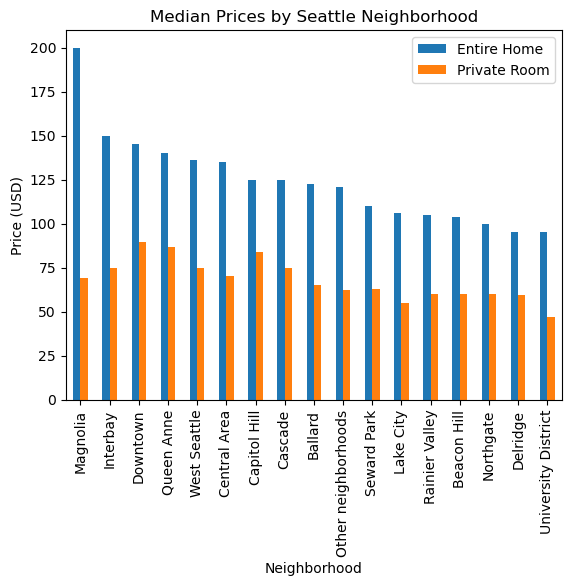

<Figure size 640x480 with 0 Axes>

In [158]:
#Get mean and median price by neighborhood
price_by_n_entire = df_entire.groupby(['Neighbourhood Group Cleansed'])['Price'].median()
price_by_n_private = df_room.groupby(['Neighbourhood Group Cleansed'])['Price'].median()

#Create dataframe of mean and median prices by neighborhood
price_by_n = pd.concat([price_by_n_entire, price_by_n_private], axis=1)
price_by_n.columns = ['Entire Home','Private Room']
price_by_n = price_by_n.sort_values(by='Entire Home', ascending=False)

#Plot
price_by_n.plot(kind="bar")
plt.title("Median Prices by Seattle Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Price (USD)")
plt.figure().clear()

### 2. Which factors are correlated with a high rating for listings?

To answer this question, we create a correlation matrix for each of the two datasets (private room and entire home). Then we isolate the Review Scores Rating column in this matrix so that we get the correlation of all other variables with the Review Scores Rating (represents the overall rating for the listing). We can see from the visualizations below that the top variables are value, cleanliness, accuracy, communication and check-in process.

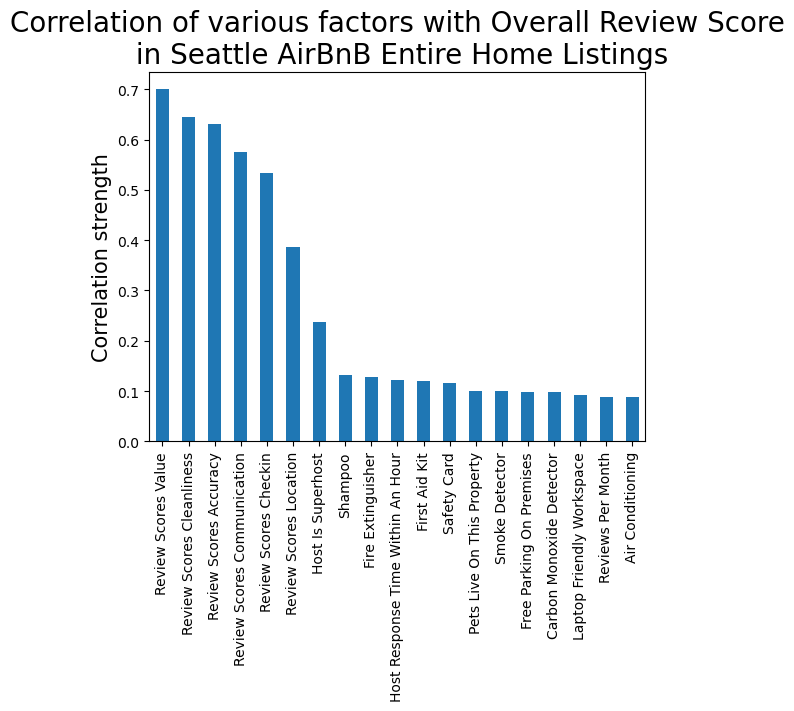

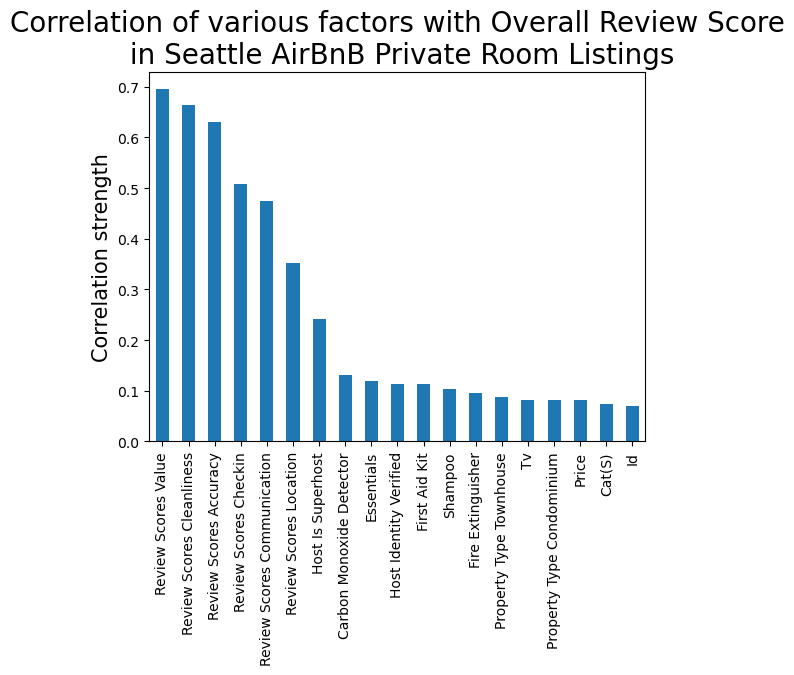

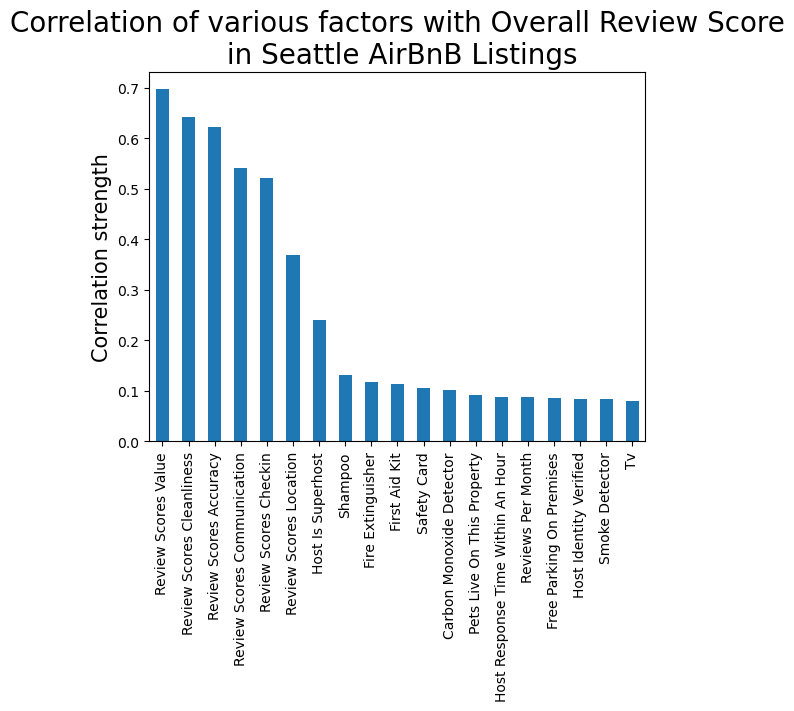

<Figure size 640x480 with 0 Axes>

In [161]:
#Correlation of Overall Review Score with all other variables for Entire home listings
cor_rev_entire = df_entire.corr()['Review Scores Rating'].sort_values(ascending=False)[1:20]
cor_rev_entire.plot(kind = 'bar')
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Overall Review Score\n in Seattle AirBnB Entire Home Listings", size = 20)
plt.figure().clear()

#Correlation of Overall Review Score with all other variables for Private room listings
cor_rev_room = df_room.corr()['Review Scores Rating'].sort_values(ascending=False)[1:20]
cor_rev_room.plot(kind = 'bar')
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Overall Review Score\n in Seattle AirBnB Private Room Listings", size = 20)
plt.figure().clear()

#Correlation of Overall Review Score with all other variables for all listings
cor_rev = df.corr()['Review Scores Rating'].sort_values(ascending=False)[1:20]
cor_rev.plot(kind = 'bar')
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Overall Review Score\n in Seattle AirBnB Listings", size = 20)
plt.figure().clear()

### 3. Which factors contribute to high prices on listings?

To answer this question, we take the correlation matrix of both datasets (private room and entire home) and we isloate the Price column. This gives us the correlation of all other variables with price.

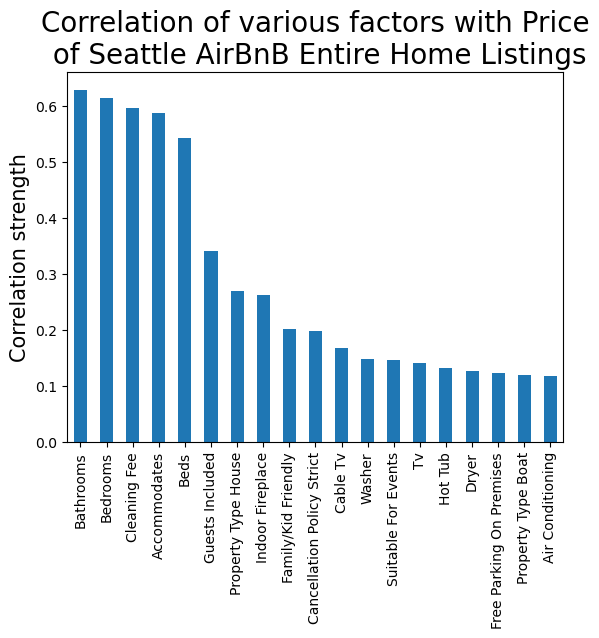

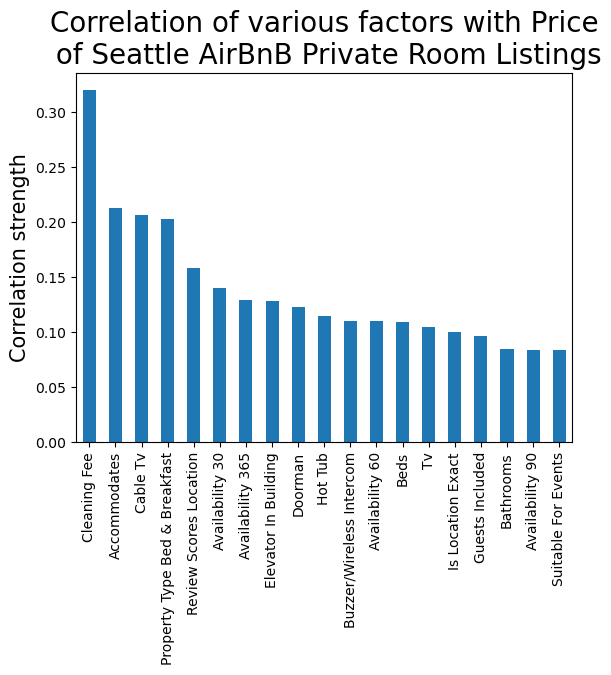

<Figure size 640x480 with 0 Axes>

In [160]:
#Correlation of Overall Review Score with all other variables for Entire Home Listings
cor_price_entire = df_entire.corr()['Price'].sort_values(ascending=False)[1:20]
cor_price_entire.plot(kind = 'bar')
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Price\n of Seattle AirBnB Entire Home Listings", size = 20)
plt.figure().clear()

#Correlation of Overall Review Score with all other variables for Private Room Listings
cor_price_room = df_room.corr()['Price'].sort_values(ascending=False)[1:20]
cor_price_room.plot(kind = 'bar')
plt.ylabel("Correlation strength", size = 15)
plt.title("Correlation of various factors with Price\n of Seattle AirBnB Private Room Listings", size = 20)
plt.figure().clear()